(50000, 28, 28) (50000,)


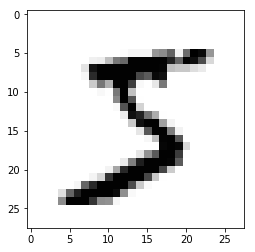

In [36]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

## Imports

In [331]:
import os
import time
import shutil
import tensorflow as tf
import numpy as np
import random
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

## Tensorflow configuration

In [13]:
! killall tensorboard

log_dir = '/tmp/tboard'

if os.path.isdir(log_dir):
    shutil.rmtree(log_dir)
os.system("tensorboard --logdir=%s --port=7007 &" % log_dir)

time.sleep(2)

s = tf.InteractiveSession()

/usr/local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Binary classification (zero vs non-zero)

In [321]:
y_train_zeros = (y_train == 0) + 0
y_test_zeros = (y_test == 0) + 0
X_train_reshaped = X_train.reshape(X_train.shape[0], 28**2)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28**2)

In [322]:
input_X = tf.placeholder('float32', shape=(None, 28 ** 2), name="input_X")
input_y = tf.placeholder('float32', shape=(None, ), name="input_y")

weights = tf.Variable(initial_value=np.random.normal(0, 0.01, size=(28 ** 2, 1)), name="weights", dtype='float32')
b = tf.Variable(initial_value=0.0, name='bias', dtype='float32')

predicted_y =  tf.squeeze(tf.nn.sigmoid(tf.matmul(input_X, weights) + b))

loss = tf.reduce_mean(-tf.log(predicted_y) * input_y - tf.log(1 - predicted_y) * (1 - input_y))

optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(loss, var_list=[weights, b])

In [323]:
s.run(tf.global_variables_initializer())
loss_i = s.run(loss, {input_X: X_train_reshaped[0:20], input_y: y_train_zeros[0:20]})
print(loss_i)

0.70658946


In [340]:
s.run(tf.global_variables_initializer())

In [343]:
from sklearn.metrics import roc_auc_score

loss_values = []
iters = []

for i in range(101):
    s.run(optimizer, {input_X: X_train_reshaped, input_y: y_train_zeros})
    if i%10 == 0:
        loss_i = s.run(loss, {input_X: X_train_reshaped, input_y: y_train_zeros})
        loss_values.append(loss_i)
        iters.append(i)
        print("loss at iter %i:%.4f" % (i, loss_i))
print("train auc:", roc_auc_score(y_train_zeros, np.rint(s.run(predicted_y, {input_X:X_train_reshaped}))))
print("test auc:", roc_auc_score(y_test_zeros, np.rint(s.run(predicted_y, {input_X:X_test_reshaped}))))

loss at iter 0:0.1596
loss at iter 10:0.1528
loss at iter 20:0.1469
loss at iter 30:0.1418
loss at iter 40:0.1372
loss at iter 50:0.1331
loss at iter 60:0.1294
loss at iter 70:0.1260
loss at iter 80:0.1230
loss at iter 90:0.1202
loss at iter 100:0.1176
train auc: 0.87503097958993
test auc: 0.8850049776007964


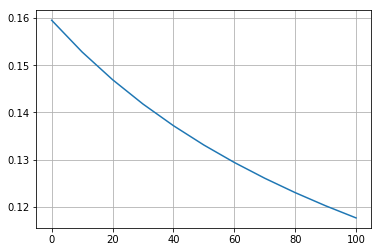

In [345]:
plt.plot(iters, loss_values)
plt.grid()

In [347]:
i = 51
print('y: ', y_train_zeros[i:i+1])
print('pred', s.run(predicted_y, {input_X: X_train_reshaped[i:i+1], input_y: y_train_zeros[i:i+1]}))

y:  [1]
pred 0.85140914


## Multiclass classification

In [351]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 28**2)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28**2)
def y2matrix(y, classes=10):
    res = np.zeros(shape=(y.shape[0], classes))
    for i, y_i in enumerate(y):
        res[i, y_i] = 1
    return res
y_train_flat = y2matrix(y_train)
y_test_flat = y2matrix(y_test)

In [352]:
input_X = tf.placeholder('float32', shape=(None, 28 ** 2), name="input_X")
input_y = tf.placeholder('float32', shape=(None, 10), name="input_y")

weights_matrix = tf.Variable(initial_value=np.random.normal(0, 0.01, size=(28 ** 2, 10)), name="weights", dtype='float32')
b_m = tf.Variable(initial_value=np.zeros(shape=(10,)), name='bias', dtype='float32')

predicted_y =  tf.squeeze(tf.nn.softmax(tf.matmul(input_X, weights_matrix) + b_m))
#predicted_y =  tf.squeeze(tf.argmax(tf.nn.softmax(tf.matmul(input_X, weights) + b)))

loss = tf.reduce_mean(-tf.log(predicted_y) * input_y - tf.log(1 - predicted_y) * (1 - input_y))

optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss, var_list=[weights_matrix, b_m])

In [353]:
s.run(tf.global_variables_initializer())
pred = s.run(predicted_y, {input_X: X_train_reshaped, input_y: y_train_flat})
print(np.argmax(pred[0]))
loss_i = s.run(loss, {input_X: X_train_reshaped, input_y: y_train_flat})
print(loss_i)

9
0.3243628


In [354]:
s.run(tf.global_variables_initializer())

In [357]:
def minibatch(X, y, n=100):
    indexes = random.sample(range(0, X.shape[0]), n)
    return X[indexes], y[indexes]

loss_values = []
iters = []
for i in range(50):
    x_train_minibatch, y_train_minibatch = minibatch(X_train_reshaped, y_train_flat)
    s.run(optimizer, {input_X: X_train_reshaped, input_y: y_train_flat})
    if i%10 == 0:
        loss_i = s.run(loss, {input_X: X_train_reshaped, input_y: y_train_flat})
        loss_values.append(loss_i)
        iters.append(i)
        print("loss at iter %i:%.4f" % (i, loss_i))
        print("train accuracy_score:", accuracy_score(y_train, np.argmax(s.run(predicted_y, {input_X:X_train_reshaped}), axis=1)))
        print("test accuracy_score:", accuracy_score(y_test, np.argmax(s.run(predicted_y, {input_X:X_test_reshaped}), axis=1)))

loss at iter 0:0.2664
train accuracy_score: 0.71724
test accuracy_score: 0.7297
loss at iter 10:0.2569
train accuracy_score: 0.7251
test accuracy_score: 0.7386
loss at iter 20:0.2479
train accuracy_score: 0.73252
test accuracy_score: 0.7475
loss at iter 30:0.2396
train accuracy_score: 0.73984
test accuracy_score: 0.7529
loss at iter 40:0.2317
train accuracy_score: 0.74618
test accuracy_score: 0.7599


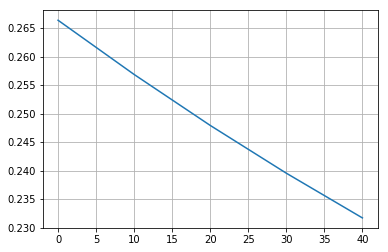

In [358]:
plt.plot(iters, loss_values)
plt.grid()

## Hidden layer

In [364]:
input_X = tf.placeholder('float32', shape=(None, 28 ** 2), name="input_X")
input_y = tf.placeholder('float32', shape=(None, 10), name="input_y")

weights_1 = tf.Variable(initial_value=np.random.normal(0, 0.01, size=(28 ** 2, 50)), name="weights1", dtype='float32')
b_m_1 = tf.Variable(initial_value=np.zeros(shape=(50,)), name='bias1', dtype='float32')
weights_2 = tf.Variable(initial_value=np.random.normal(0, 0.01, size=(50, 10)), name="weights2", dtype='float32')
b_m_2 = tf.Variable(initial_value=np.zeros(shape=(10,)), name='bias2', dtype='float32')

hidden_output = tf.nn.sigmoid(tf.matmul(input_X, weights_1) + b_m_1)
predicted_y =  tf.squeeze(tf.nn.softmax(tf.matmul(hidden_output, weights_2) + b_m_2))
#predicted_y =  tf.squeeze(tf.argmax(tf.nn.softmax(tf.matmul(input_X, weights) + b)))

loss = tf.reduce_mean(-tf.log(predicted_y) * input_y - tf.log(1 - predicted_y) * (1 - input_y))

optimizer = tf.train.GradientDescentOptimizer(20.0).minimize(loss, var_list=[weights_1, b_m_1, weights_2, b_m_2])

In [377]:
s.run(tf.global_variables_initializer())
pred = s.run(hidden_output, {input_X: X_train_reshaped, input_y: y_train_flat})
print(pred[0])
loss_i = s.run(loss, {input_X: X_train_reshaped, input_y: y_train_flat})
print(loss_i)

[0.48872232 0.5029412  0.4890359  0.51322633 0.5136747  0.48962408
 0.52376246 0.49014693 0.5007235  0.47836283 0.48768198 0.52901065
 0.51027113 0.4798206  0.5202026  0.511184   0.49870944 0.5105344
 0.47886255 0.49041125 0.55182374 0.51203555 0.48340026 0.5497394
 0.5369637  0.46772373 0.53759766 0.4774647  0.5134394  0.5260604
 0.46930924 0.43029368 0.5418696  0.49170908 0.51147574 0.44876626
 0.50852776 0.50332576 0.50923115 0.53425944 0.46932784 0.51733106
 0.5012069  0.52180684 0.46777755 0.46810374 0.5048769  0.46452293
 0.50690854 0.48962533]
0.32525387


In [378]:
loss_values = []
iters = []
j = 0

### After a while the score of accuracy will reach 0.96

In [395]:
def minibatch(X, y, n=100):
    indexes = random.sample(range(0, X.shape[0]), n)
    return X[indexes], y[indexes]

for i in range(101):
    x_train_minibatch, y_train_minibatch = minibatch(X_train_reshaped, y_train_flat)
    s.run(optimizer, {input_X: X_train_reshaped, input_y: y_train_flat})
    
    if i%10 == 0:
        loss_i = s.run(loss, {input_X: X_train_reshaped, input_y: y_train_flat})
        
        loss_values.append(loss_i)
        iters.append(j)
        j += 10
    
        print("loss at iter %i:%.4f" % (i, loss_i))
        print("train accuracy_score:", accuracy_score(y_train, np.argmax(s.run(predicted_y, {input_X:X_train_reshaped}), axis=1)))
        print("test accuracy_score:", accuracy_score(y_test, np.argmax(s.run(predicted_y, {input_X:X_test_reshaped}), axis=1)))

loss at iter 0:0.0177
train accuracy_score: 0.97194
test accuracy_score: 0.9644
loss at iter 10:0.0176
train accuracy_score: 0.97232
test accuracy_score: 0.9646
loss at iter 20:0.0174
train accuracy_score: 0.97254
test accuracy_score: 0.9649
loss at iter 30:0.0173
train accuracy_score: 0.97266
test accuracy_score: 0.9652
loss at iter 40:0.0171
train accuracy_score: 0.97296
test accuracy_score: 0.9654
loss at iter 50:0.0170
train accuracy_score: 0.97326
test accuracy_score: 0.9654
loss at iter 60:0.0168
train accuracy_score: 0.97364
test accuracy_score: 0.9654
loss at iter 70:0.0167
train accuracy_score: 0.97398
test accuracy_score: 0.9655
loss at iter 80:0.0166
train accuracy_score: 0.97414
test accuracy_score: 0.9655
loss at iter 90:0.0164
train accuracy_score: 0.97442
test accuracy_score: 0.9657
loss at iter 100:0.0163
train accuracy_score: 0.97472
test accuracy_score: 0.9655


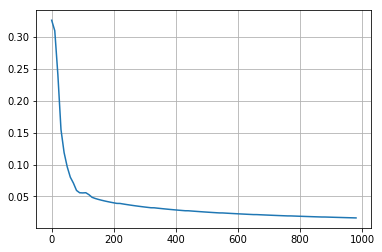

In [396]:
plt.plot(iters, loss_values)
plt.grid()